# Clustering

Conforme visto no notebook anterior não foi possível obter bons resultados com dados. Assim iremos propor aqui utilizar apenas as amostras nas quais as pessoas utilizaram o Canabidiol (CBD), realizando uma clusterização em cima desses dados.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from scipy.stats import f_oneway

#Estilo ggplot
plt.style.use('ggplot')

# 1. Leitura dos dados

In [2]:
#Setando diretorio Data como o atual
os.chdir('../Data')

#Leitura
df_parkinson = pd.read_csv('parkinson_v2.csv',index_col = 'name')

# 2. Transformação dos dados

Nessa seção iremos criar os outros atributos para wpsf seguindo a fórmula wpsf = psp * pspf. Também faremos uma diminuição das features no domínio da frequência ao calcular sua média por amostra.

Por fim, aplicaremos o log no intuito de distribuir mais os valores das features (existe uma assimetria muito grande) e iremos padronizá-las para o intervalo [0,1].

In [3]:
#Selecionando pessoas que tomaram CBD
df_parkinson = df_parkinson.loc[df_parkinson['drug'] == 'CBD']

#Criacao de novas colunas
df_parkinson['wpsf2'] = df_parkinson['pspf2'] * df_parkinson['psp2']
df_parkinson['wpsf3'] = df_parkinson['pspf3'] * df_parkinson['psp3']
df_parkinson.rename(columns={'wpsf':'wpsf1'},inplace=True)

#Medias dos psp's e pspf's
df_parkinson['psp'] = df_parkinson[['psp1','psp2','psp3']].apply(lambda x: x.mean(),axis=1)
df_parkinson['pspf'] = df_parkinson[['pspf1','pspf2','pspf3']].apply(lambda x: x.mean(),axis=1)
df_parkinson['wpsf'] = df_parkinson[['wpsf1','wpsf2','wpsf3']].apply(lambda x: x.mean(),axis=1)

#Dropando colunas que nao sai mais interessantes
df_parkinson = df_parkinson.drop(columns=['drug','evaluate','measure','psp1','psp2','psp3','pspf1','pspf2','pspf3','wpsf1','wpsf2','wpsf3'])

#Aplicando log
positive_cols = (df_parkinson <= 0).any()
positive_cols = positive_cols[~positive_cols].index
df_parkinson.loc[:,positive_cols] = np.log(df_parkinson.loc[:,positive_cols])

#Reescalando variaveis
mm = MinMaxScaler().fit(df_parkinson)
df_parkinson.iloc[:,:] = mm.transform(df_parkinson)

# 3. Modelagem - Testes

## 3.1 Redução de dimensionalidade e clusterização com todos os atributos

Como temos muitos atributos iremos aplicar o PCA para reduzir a dimensionalidade dos dados e em seguida realizar a clusterização.

In [4]:
'''Plota varios boxplot definido por x e cols'''
def boxplot(df,cols,x):
    
    #Iremos plotar 3 graficos por linhas
    ncol = 3
    
    #Numero de linhas é calculado automaticamente
    nrow = int(len(cols)/3)+1
    
    fig = plt.figure(figsize=(15,15))
    fig.subplots_adjust(wspace=0.3,hspace=0.3)
    for index,c in enumerate(cols):
        ax = fig.add_subplot(nrow,ncol,index+1)
        ax.xaxis.label.set_size(15)
        ax.yaxis.label.set_size(15)
        sns.boxplot(data=df,x=x,y=c)
    plt.show()
    
'''Plota um pairplot customizado'''
def pairplot(df,col_plot,hue):
    
    #Pairplot
    g = sns.pairplot(data=df,hue=hue,vars=col_plot)

    #Quantidade de colunas para plotar
    n = len(col_plot)
    
    #Customizando figura
    for index in range(n):
        
        #Muda o tamanho de xticklabels 
        for tick_x in g.axes[n-1][index].get_xticklabels():
            tick_x.set_fontsize(13)

        #Muda o tamanho de yticklabels
        for tick_y in g.axes[index][0].get_yticklabels():
            tick_y.set_fontsize(13)

        #Muda o tamanho de xlabel/ylabel
        g.axes[n-1][index].xaxis.label.set_size(15)
        g.axes[index][0].yaxis.label.set_size(15)

    #Muda tamanho das legendas
    g.fig.get_children()[-1].properties()['title'].set_fontsize(15)
    g.fig.get_children()[-1].prop.set_size(15)
    plt.show()
    
'''Plot da variância explicada do PCA'''
def plot_pca(pca,size):
    #Plot dos 'size' primeiros PC's
    x_list = []
    for i in range(size):
        x_list.append('PC' + str(i+1))

    #Criando figura
    fig,ax = plt.subplots(figsize=(15,7))
    ax.set_title('Explained variance by different principal components')
    ax.bar(height=pca.explained_variance_ratio_[0:size],x=x_list,width=0.9,label='Individual')
    ax.plot(x_list,np.cumsum(pca.explained_variance_ratio_[0:size]),marker='o',color='orange',label='Cumulative')
    
    #Rotaciona xticklabels em 45 graus
    for xtick in ax.get_xticklabels():
        xtick.set_rotation(45)
    
    ax.legend()
    plt.show()
    
'''Plot dos loagind vectors do PCA com os dados transformados.'''
def plot_pca_loading(df_pca,df_loading,hue=None):
    
    #Criando figura
    fig , ax = plt.subplots(figsize=(9,7))

    #Scatterplot
    sns.scatterplot(x='PC1',y='PC2',data=df_pca,hue=hue,palette='seismic',ax=ax)

    #Setando limites nos eixos
    ax.set_xlim(-1,1.5)
    ax.set_ylim(-1,1.5)

    #Linhas de referencia
    ax.hlines(0,-1.5,1.5, linestyles='dotted', colors='grey')
    ax.vlines(0,-1.5,1.5, linestyles='dotted', colors='grey')

    #Labels em x/y
    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Second Principal Component')

    #Plot dos labels e vetores
    offset = 1.3 #Offset para separar os labels dos vetores
    shift = 0.05 #Shift dos labels com os vetores
    for index,value in df_loading.iterrows():
        #Labels
        ax.annotate(index, (value['V1']*offset+shift, value['V2']*offset), color='darkblue',fontsize=15)

        #Vetores
        ax.arrow(0,0,value['V1']*offset, value['V2']*offset,color='black',width=0.02)

    plt.show()
    
'''Aplica a transformação pca nos dados.'''
def pca_transform(pca,df,n):
    #Criando dataframe a partir da transformacao do pca
    df_pca = pd.DataFrame(pca.transform(df)[:,0:n])

    #Loading vectors
    df_loading = pd.DataFrame(pca.components_,index=df.columns,columns=['V' + str(i+1) for i in range(len(pca.components_))])

    #Renomeando colunas
    df_pca.columns = ['PC' + str(c+1) for c in df_pca.columns]
    
    return df_pca,df_loading

'''Plota um gráfico de radar.'''
def radar_plot(df):
        
    #Numero de features
    features = df.columns.values
    N = len(features)

    #Deixando em maiusculo
    features = [i.upper() for i in features]

    #Inicializa figura
    plt.figure(figsize=(7,7))
    ax = plt.subplot(111, polar=True)
    ax.set_title('Comparação das características em cada grupo')

    #Plota um radar plot para cada amostra
    for i in range(len(df)):

        #Valores a serem plotados
        values = df.iloc[i].values.tolist()

        #Angulos para o plot
        angles = [n / float(N) * 2 * pi for n in range(N)]

        #Tornando circular
        values += values[:1]
        angles += angles[:1]

        # Draw one axe per variable + add labels labels yet
        plt.xticks(angles[:-1], features, color='grey', size=13)

        #Plot os dados
        ax.plot(angles, values, linewidth=1, linestyle='solid')

        #Preenche area
        ax.fill(angles, values, 'b', alpha=0.1)

    #Ylabels
    ax.set_rlabel_position(0)
    yticks = np.linspace(df.values.min(),df.values.max(),4)
    plt.yticks(yticks[:-1], [str(round(i,2)) for i in yticks[:-1]], color="grey", size=13)
    plt.ylim(0,yticks[-1])
        
    #Legenda
    ax.legend(['Grupo ' + str(i) for i in range(len(df))])
    plt.show()

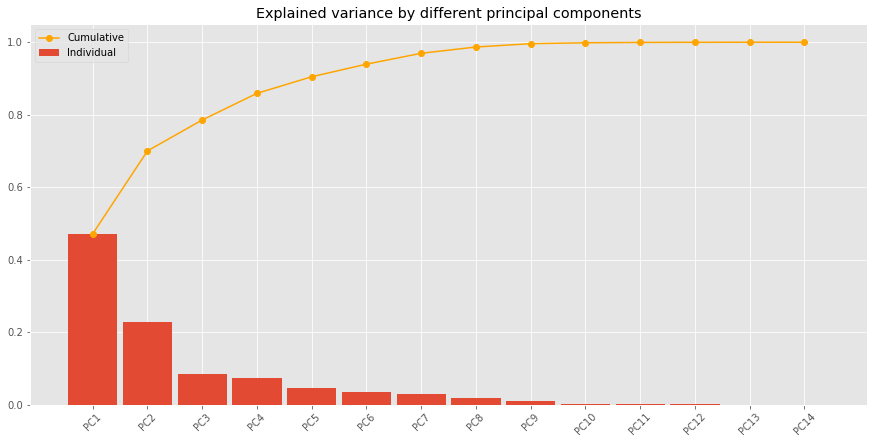

In [5]:
#Criando o PCA
pca = PCA().fit(df_parkinson)

#Plot dos PC's
plot_pca(pca,df_parkinson.shape[1])

Até o quinto PC temos aproximadamente 90% de explicação dos dados. Logo, vamos utilizar os 5 primeiros componentes.

In [6]:
#Transformando dados
df_pca,df_loading = pca_transform(pca,df_parkinson,5)

Vamos aplicar a clusterização nos dados após o PCA.

In [7]:
#Criando KMeans
kmeans = KMeans(n_clusters=4,random_state=0).fit(df_pca.select_dtypes('float'))

#Predizendo classes
df_pca['target'] = kmeans.predict(df_pca.select_dtypes('float'))

Vamos plotar os dados para ver o que podemos interpretar.

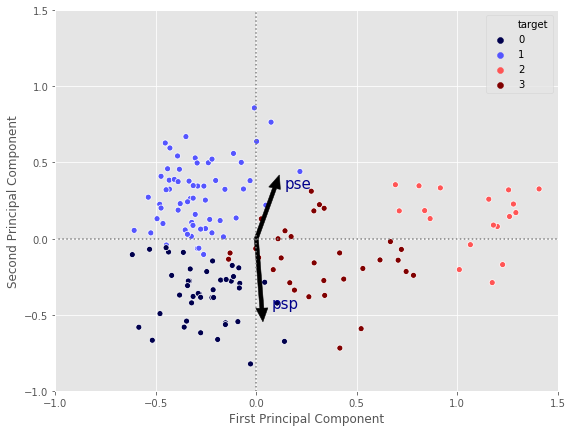

In [8]:
#Filtrando pelos valores necessarios para o plot
df_loading = df_loading.loc[['pse','psp'],['V1','V2']]

# PCA plot
plot_pca_loading(df_pca,df_loading,'target')

Podemos ver pela figura acima que o grupo 0 possui os maiores,menores valores de PSP,PSE respectivamente. Assim, provavelmente esse grupo é o que mais sofreu efeito do CBD. 

O grupo 1 é o oposto do 0, logo, tais pessoas não sofreram tanto efeito.

## 3.2 Clusterização sem PCA em features no domínio da frequência

Muitos dos atributos gerados não possuem um significado interessante para avaliar os clusters. Por causa disso faremos uma clusterização nos seguintes atributos:

- psp
- pse
- pspf

E então avaliaremos os resultados também.

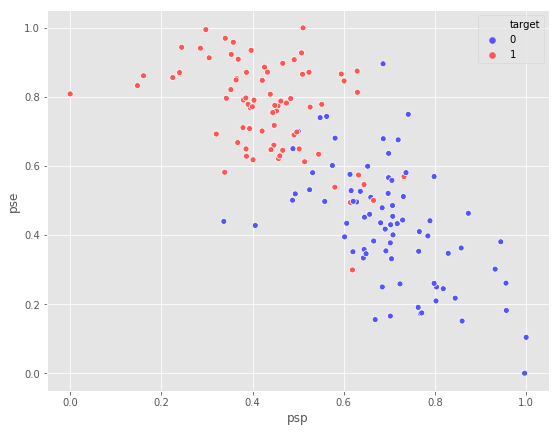

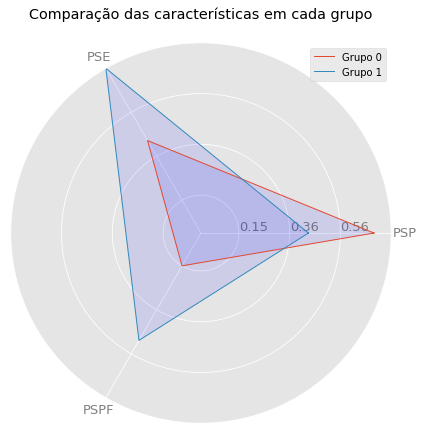

In [9]:
#Copiando dados
df_plot = df_parkinson[['psp','pse','pspf']].copy()

#Criando KMeans
kmeans = KMeans(n_clusters=2,random_state=0).fit(df_plot)

#Predizendo as classes
df_plot['target'] = kmeans.predict(df_plot)

#Scatterplot
fig,ax = plt.subplots(figsize=(9,7))
sns.scatterplot(x='psp',y='pse',data=df_plot,palette='seismic',hue='target',ax=ax)
plt.show()

#Radar plot
radar_plot(df_plot.groupby('target').mean())

Note que o grupo 0 é o mais afetado pelo CBD enquanto o 1 seria o oposto.

Lembrando que valores maiores de psp indicam movimentos mais regulares e valores menores de pse indicam movimentos mais suave.

No radar plot acima podemos verificar a média dos dois grupos. Note que a tendência do 0 é as pessoas terem um efeito maior sobre o CBD.

# 4. Estatísticas dos clusters

Pelas modelagens acima verificamos que é possível utilizar duas abordagens, ou seja, em ambas conseguimos bons resultados.

Iremos a seguir trabalhar em cima da clusterização sem PCA nos atributos pse, psp e pspf para gerar estatísticas dos clusters.

In [10]:
#Restaurando dados originais
df_parkinson = pd.DataFrame(mm.inverse_transform(df_parkinson),columns=df_parkinson.columns)

#Salvando dados - criando um backup
df_parkinson[['pse','psp','pspf']].to_csv('parkinson_clustering.csv',index=False)

In [11]:
#Leitura
df_parkinson = pd.read_csv('parkinson_clustering.csv')

In [12]:
'''
    Realiza a clusterização com o kmeans
    Retorna uma cópia do dataframe com a classe predita.
'''
def clustering(df,normalize=True,n_clusters=2):
    
    #Copia dataframe
    df_cluster = df.copy()
    
    #Normaliza
    if(normalize):
        df_cluster = pd.DataFrame(MinMaxScaler().fit_transform(df_cluster),columns=df_cluster.columns)
    
    #Criando KMeans
    kmeans = KMeans(n_clusters=n_clusters).fit(df_cluster)

    #Predizendo clusters
    df_cluster['target'] = kmeans.predict(df_cluster)
    
    return df_cluster

In [13]:
#Clusterizando
df_cluster = clustering(df_parkinson,n_clusters=2)

In [14]:
#Estatísticas de cada grupo - média
df_cluster.groupby('target').mean()

,pse,psp,pspf
target,,,
0,0.767464,0.433526,0.500116
1,0.430914,0.698101,0.152786


/home/sugi/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


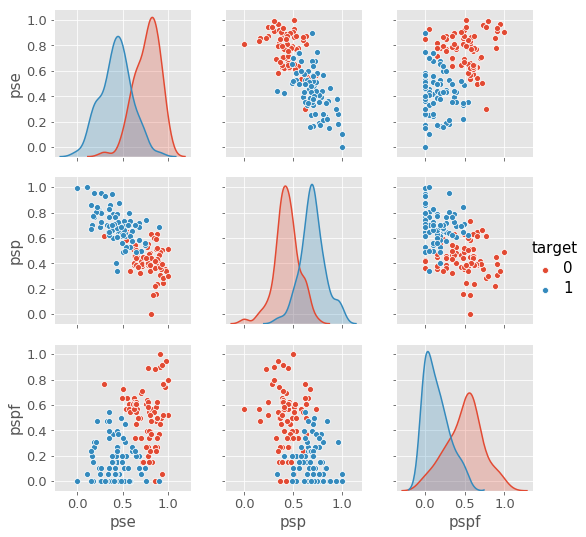

In [15]:
#Pairplot
pairplot(df_cluster,df_cluster.columns[:-1],'target')

Vamos verificar se existem diferenças significativas nos grupos em pse e psp por meio da ANOVA.

In [16]:
#ANOVA
_,pvalue = f_oneway(df_cluster.loc[df_cluster['target'] == 0].select_dtypes('float'),df_cluster.loc[df_cluster['target'] == 1].select_dtypes('float'))
dict(zip(df_cluster.columns.values[:-1],pvalue))

{'pse': 7.705213824555663e-28,
 'psp': 1.7854992746229686e-26,
 'pspf': 1.0933246513146703e-21}

Pelo ANOVA verificamos que existem diferenças nos grupos em todos os atributos.